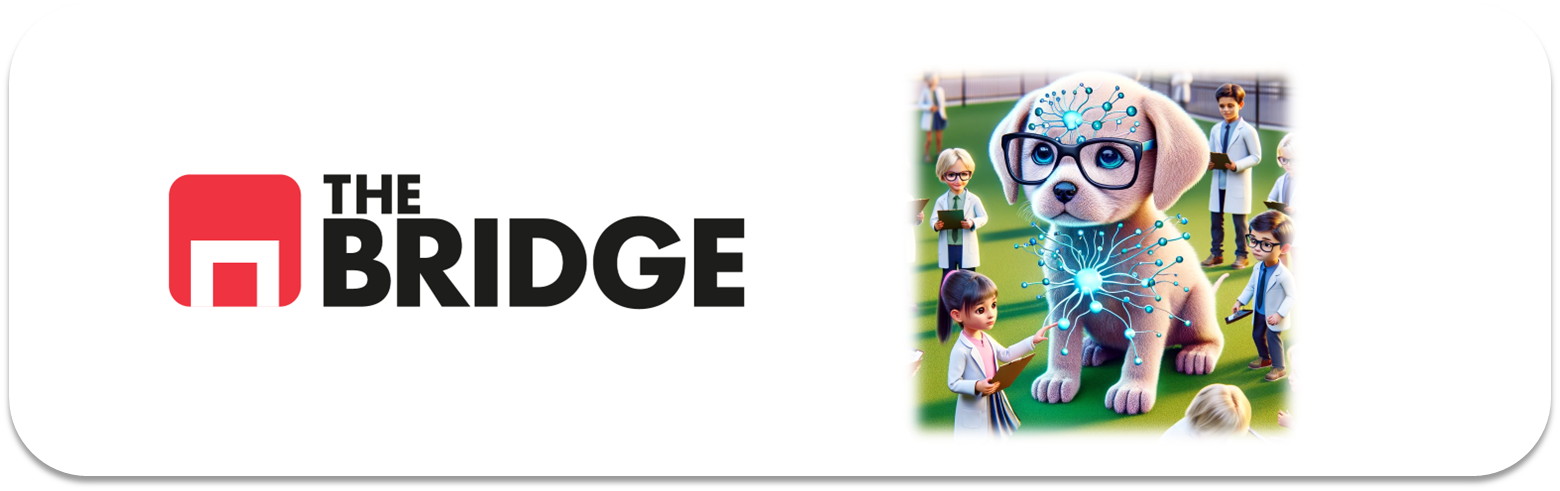

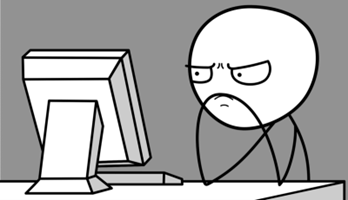

Para ejercitarte y afianzar lo aprendido sobre **Redes Recurrentes y series temporales**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

### Problema a resolver

El ayuntamiento de New City está preocupado por el nivel de contaminación de aire y quiere poner en marcha un sistema de prevención del uso de determinado tipo de vehículos y maquinaria pesada en aquellos días en los que la contaminación sea muy alta, en concreto queremos anticiparnos en periodos de 6 horas. Como primer paso para la implantación de la medida, decide crear un modelo de predicción de contaminación de forma que pueda emplearlo para enviar alertas o avisos de posible de prohibición con la suficiente anticipación que permita a los ciudadanos y trabajadores organizarse mejor. 

Para ello nos ha suministrado una serie de datos de contaminación del aire en cinco años dependiente de una serie de features que son medibles día a día y nos pide crear dicho modelo. Como somos unos "pioneros" vamos a hacerlo empleando lo aprendido con redes recurrentes.

A través de los siguientes ejercicios vamos a crear un modelo de regresión que permita estimar dicha polución en los periodos estimados. Aquí tienes un breve descripción de las columnas:

- **No**: número de fila
- **year**: año de los datos en esta fila
- **month**: mes de los datos en esta fila
- **day**: día de los datos en esta fila
- **hour**: hora de los datos en esta fila
- **pm2.5**: concentración de PM2.5
- **DEWP**: Punto de rocío
- **TEMP**: Temperatura
- **PRES**: Presión
- **cbwd**: Dirección combinada del viento
- **Iws**: Velocidad acumulada del viento
- **Is**: Horas acumuladas de nieve
- **Ir**: Horas acumuladas de lluvia


### Ejercicio 1: Visión preliminar

Carga el dataset. Echa un vistazo (no pintes series todavía) y decide cuál debe ser el target.

In [4]:
df = pd.read_csv("data/air_pollution_new_city.csv", sep = "|")

In [5]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,25,2019,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,26,2019,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,27,2019,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,28,2019,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,29,2019,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43800 non-null  int64  
 1   year    43800 non-null  int64  
 2   month   43800 non-null  int64  
 3   day     43800 non-null  int64  
 4   hour    43800 non-null  int64  
 5   pm2.5   43800 non-null  float64
 6   DEWP    43800 non-null  int64  
 7   TEMP    43800 non-null  float64
 8   PRES    43800 non-null  float64
 9   cbwd    43800 non-null  object 
 10  Iws     43800 non-null  float64
 11  Is      43800 non-null  int64  
 12  Ir      43800 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


*No hay nulos, y parece que el dataset empieza el 2 de enero de 2019, nos falta el primer día. No vamos a considerar que tenga mucho impacto teniendo 43800 horas de datos*

*Solo hay una variable categórica que es la dirección combinada del viento y el resto son numéricas (en definitiva son series :-), es un dataset multivariado o multivariante*

*El target parece claramente (por descarte) la columna pm2.5 así que la marcamos como tal*

In [7]:
target = "pm2.5"

### Ejercicio 2: Preparación del dataset

Como todo dataset con series temporales, si tenemos las fechas, es conveniente convertirla a datatime y luego hacerlo el indice de nuestro dataset. Hazlo sobre un dataframe df_indexed copia del original. Deshazte de las columnas que no sean informativas y cambia el nombre de las columnas para que sean más "expresivas".

*Eliminamos No que es básicamente un índice*

In [8]:
df.drop("No", axis = 1, inplace = True)

*Renombramos columnas*

In [9]:
df.rename(columns={"DEWP":"rocio","TEMP":"temperatura","PRES":"presion","cbwd":"dir_viento","Iws":"vel_viento","Is":"horas_nieve","Ir":"horas_lluvia"}, inplace = True)

*Preparando el índice*

In [ ]:
date_columns = ["year","month","day","hour"]
df["fecha"] = pd.to_datetime(df[date_columns])

df_indexed = df.set_index("fecha")
df_indexed.sort_index(inplace = True)
df_indexed.drop(date_columns, axis =1, inplace = True)

### Ejercicio 3: Split y MiniEda_I

Antes de continuar es hora analizar visualmente las series, pero para hacerlo formalmente correcto, analiza sólo de 2019 a 2022 (2023 será nuestro periodo de validaciones y test). Crea una gráfica com el target para el periodo de train. Descompón la serie de forma aditiva y analiza visualmente si existe estacionalidad, tendencia y si podríamos decir si es estacionaria o no

*Primero nos creamos el dataset de train*

In [11]:
df_train = df_indexed[:"2022"]

*Vamos con el análisis del target*

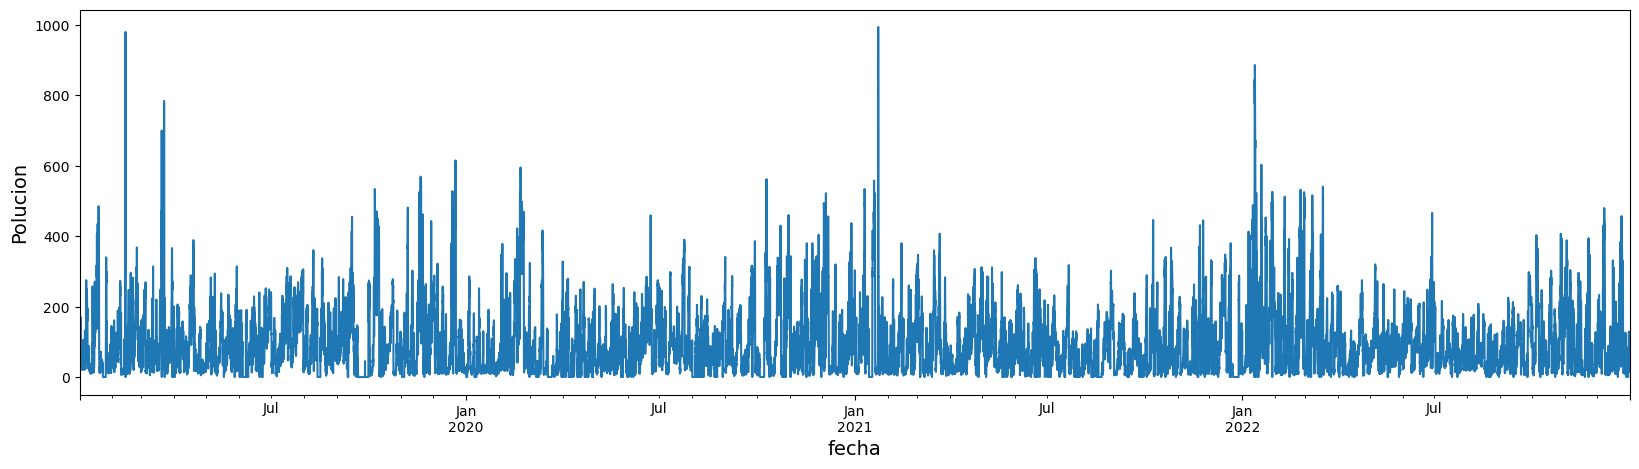

In [12]:
df_train[target].plot(figsize = (20,5))
plt.ylabel("Polucion");


*Así tal cual no se ve mucho en terminos de trend o sesonality. Hagamos una descomposición*

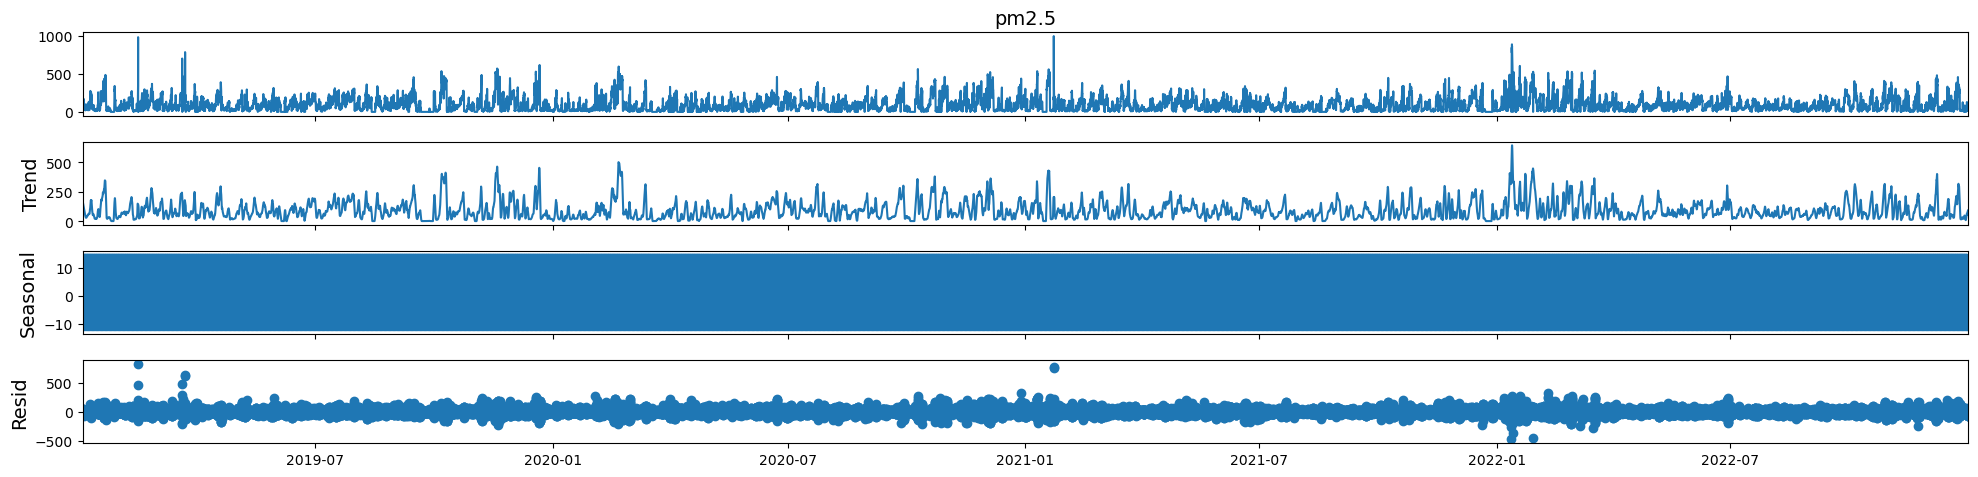

In [13]:
result_add = seasonal_decompose(df_train[target], model = 'additive', extrapolate_trend = 'freq')
# Plot
plt.rcParams.update({'figure.figsize': (20,5)})
result_add.plot();

In [14]:
df_train[target].describe()

count    35040.000000
mean        93.359389
std         91.908697
min          0.000000
25%         24.000000
50%         67.000000
75%        133.000000
max        994.000000
Name: pm2.5, dtype: float64

*Aunque puede parecer que existe una componente estacional, los niveles de la misma son mínmos (+-10 sobre valores medios de 90) y la tendencia sigue básicameente a la serie. No podemos estar seguros de que exista una estacionalidad o tendencia a NIVEL HORARIO*

In [15]:
result = adfuller(df_train[target].values)
result[1]

0.0

*Si hacemos el test de Dickey-Fuller aumentado nos dice que podemos tratar la serie como estacionaria*

*Podríamos probar un ARIMA directamente sin diferenciar, pero lo haremos con redes*

### Ejercicio 4: MiniEDA (II)

Para completar el minieda, crea una figura con tantos subplots como series temporales y en cada subplot muestra una de las series para el train. Empieza por el target y haz un pequeño análisis visual. Por supuesto, emplea sólo el train

In [16]:
series_col = [target] + [col for col in df_train.columns if df_train[col].dtype != "object" and col != target]
series_col

['pm2.5',
 'rocio',
 'temperatura',
 'presion',
 'vel_viento',
 'horas_nieve',
 'horas_lluvia']

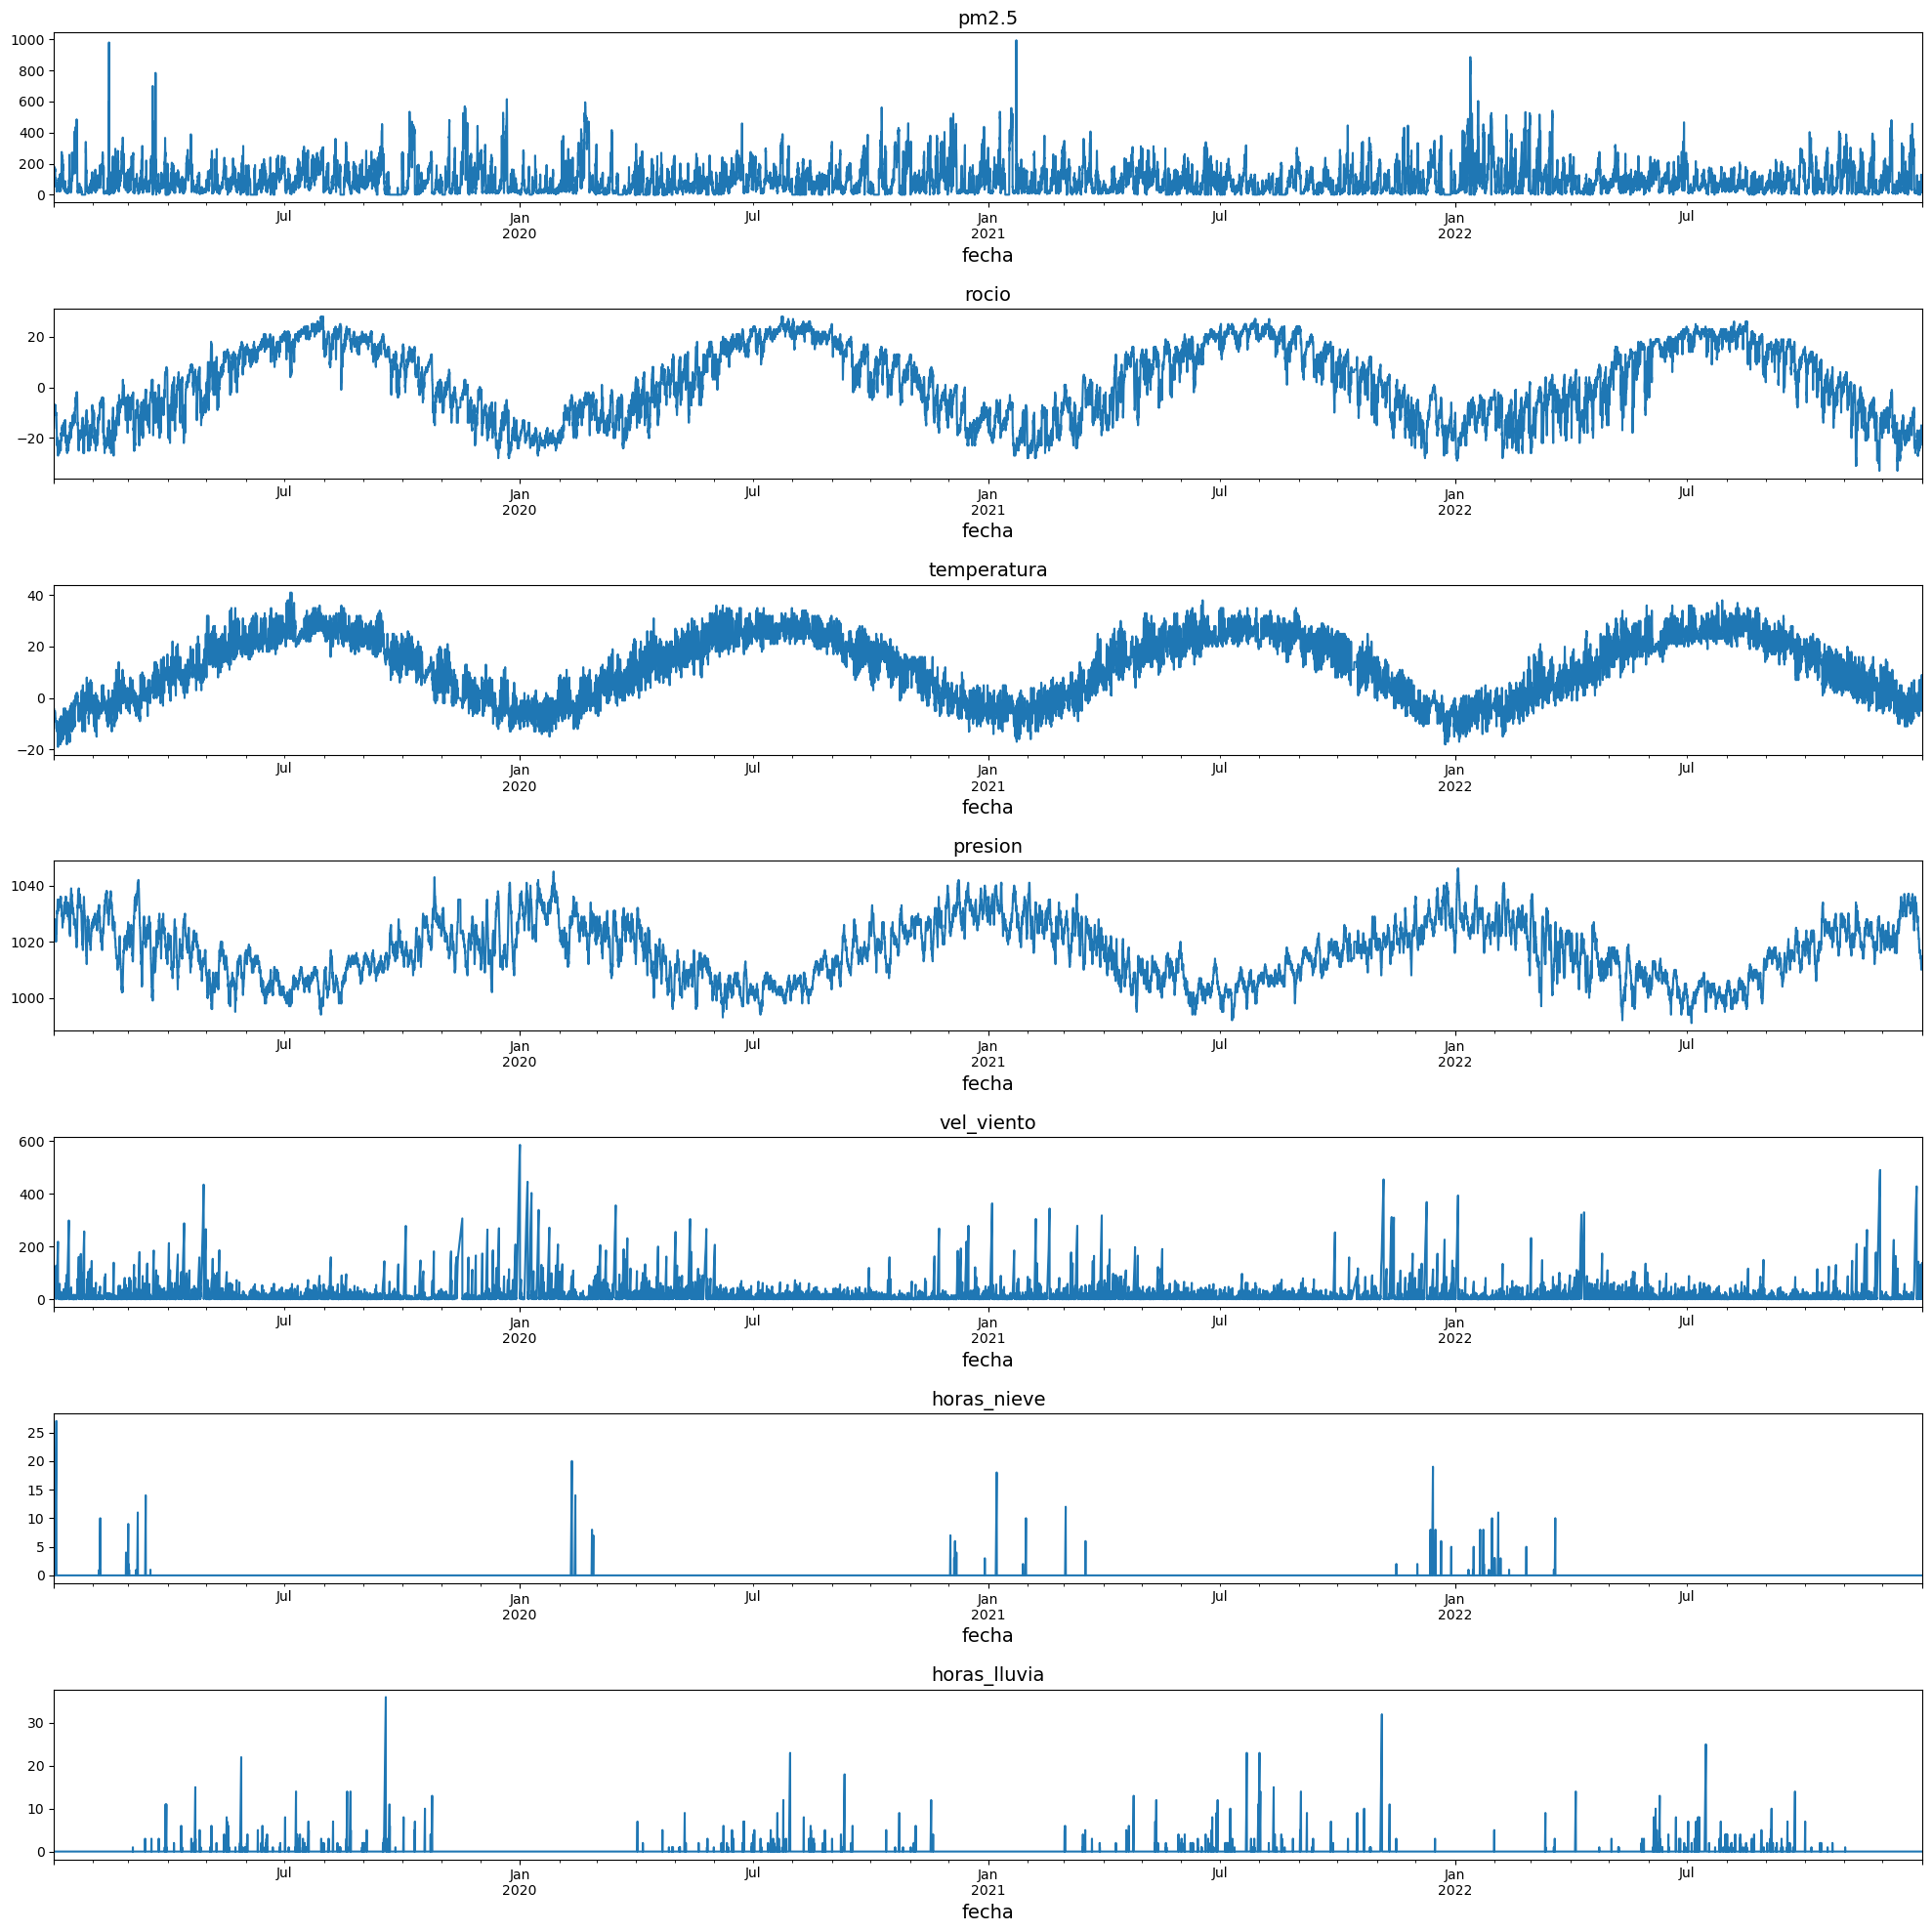

In [17]:
fig,axs = plt.subplots(len(series_col),1, figsize = (20,20))
for indice,col in enumerate(series_col):
    df_train[col].plot(ax = axs[indice])
    axs[indice].set_title(col)
plt.tight_layout();
    

*Así de primeras, parece que la nieve y el viento aumentan la contaminación y es la lluvia la que la disminuye o por lo menos que existen correlaciones con estos procesos, y con las medidas de presión,temperatura y punto de rocío de estos fenómenos*

### Ejercicio 5

Vamos a preparar el dataset. En principio vamos a predecir el valor de las siguientes 12 horas a partir de las 48 horas anteriores. Es decir hay que ajustar el dataset para que genere batches de 32 secuencias de 48 instancias y con un target que es una secuencia de los 12 periodos siguientes. Primero codifica la dirección del viento con un one-hot encoding sobre el df_indexed. Convierte todos los valores a np.float32 al final: 

In [18]:
df_indexed["dir_viento"].value_counts()

dir_viento
SE    15290
NW    14130
cv     9384
NE     4996
Name: count, dtype: int64

In [19]:
from sklearn.preprocessing import OneHotEncoder

col_onehot = [f"dir_viento_{valor}" for valor in df_indexed["dir_viento"].unique()]
onehot = OneHotEncoder()
df_indexed[col_onehot] = onehot.fit_transform(df_indexed[["dir_viento"]]).toarray()
df_indexed.drop("dir_viento", axis = 1, inplace = True)

*Lo hacemos sobre df_indexed porque las direcciones del viento son las que son, no van a aparecer unas nuevas en principio (es algo "estipulado") y podemos saberlas con antelación (ojo, no los valores de cada hora sino las "etiquetas" de la variable)*

In [20]:
df_indexed = df_indexed.astype(np.float32)

In [24]:
df_indexed

,pm2.5,rocio,temperatura,presion,vel_viento,horas_nieve,horas_lluvia,dir_viento_SE,dir_viento_cv,dir_viento_NW,dir_viento_NE
fecha,,,,,,,,,,,
2019-01-02 00:00:00,129.0,-16.0,-4.0,1020.0,1.790000,0.0,0.0,0.0,0.0,1.0,0.0
2019-01-02 01:00:00,148.0,-15.0,-4.0,1020.0,2.680000,0.0,0.0,0.0,0.0,1.0,0.0
2019-01-02 02:00:00,159.0,-11.0,-5.0,1021.0,3.570000,0.0,0.0,0.0,0.0,1.0,0.0
2019-01-02 03:00:00,181.0,-7.0,-5.0,1022.0,5.360000,1.0,0.0,0.0,0.0,1.0,0.0
2019-01-02 04:00:00,138.0,-7.0,-5.0,1022.0,6.250000,2.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,8.0,-23.0,-2.0,1034.0,231.970001,0.0,0.0,0.0,1.0,0.0,0.0
2023-12-31 20:00:00,10.0,-22.0,-3.0,1034.0,237.779999,0.0,0.0,0.0,1.0,0.0,0.0
2023-12-31 21:00:00,10.0,-22.0,-3.0,1034.0,242.699997,0.0,0.0,0.0,1.0,0.0,0.0


In [25]:
series_col

['rocio',
 'temperatura',
 'presion',
 'vel_viento',
 'horas_nieve',
 'horas_lluvia']

### Ejercicio 6

Ahora crea los datasets de train, validación y test. El primero para que tenga el periodo 2020 septiembre de 2023, el segundo para octubre de 2023 y el tercero para noviembre de 2023. Ojo ten en cuenta que vamos a necesitar tanto los valores anteriores como posteriores en los periodos (48 horas antes y 12 horas después). Escálalos (importante, escala el target por separado para poder hacer la inversión en el momento de evaluar)

In [21]:
df_train_mulvar = df_indexed[:"2023-09"].copy()
df_valid_mulvar = df_indexed["2023-09-29":"2023-11-01"].copy()
df_test_mulvar = df_indexed["2023-10-30":"2023-12-01"].copy()

In [22]:
from sklearn.preprocessing import StandardScaler

series_col.remove(target)
scaler = StandardScaler()
df_train_mulvar[series_col] = scaler.fit_transform(df_train_mulvar[series_col])
df_valid_mulvar[series_col] = scaler.transform(df_valid_mulvar[series_col])
df_test_mulvar[series_col] = scaler.transform(df_test_mulvar[series_col])

scaler_target = StandardScaler()
df_train_mulvar[[target]] = scaler_target.fit_transform(df_train_mulvar[[target]])
df_valid_mulvar[[target]] = scaler_target.transform(df_valid_mulvar[[target]])
df_test_mulvar[[target]] = scaler_target.transform(df_test_mulvar[[target]])


In [27]:
df_train_mulvar.describe().T

,count,mean,std,min,25%,50%,75%,max
pm2.5,41592.0,3.668684e-09,1.000015,-1.024619,-0.750269,-0.278387,0.423949,9.883539
rocio,41592.0,1.907716e-08,1.000011,-2.907129,-0.839877,0.055933,0.951742,1.778643
temperatura,41592.0,3.375189e-08,1.000024,-2.587710,-0.879325,0.096896,0.829061,2.374743
presion,41592.0,-4.402420e-09,1.000017,-2.430524,-0.781518,-0.102516,0.770487,2.904495
vel_viento,41592.0,2.934947e-09,1.000023,-0.473415,-0.445871,-0.372284,-0.024852,11.554367
horas_nieve,41592.0,-7.337367e-10,0.999951,-0.071169,-0.071169,-0.071169,-0.071169,34.527039
horas_lluvia,41592.0,-7.337367e-09,1.000009,-0.139790,-0.139790,-0.139790,-0.139790,24.754339
dir_viento_SE,41592.0,1.142527e-01,0.318064,0.000000,0.000000,0.000000,0.000000,1.000000
dir_viento_cv,41592.0,3.176092e-01,0.465604,0.000000,0.000000,0.000000,1.000000,1.000000
dir_viento_NW,41592.0,3.569196e-01,0.479069,0.000000,0.000000,0.000000,1.000000,1.000000


### Ejercicio 7

Prepara los batches siguiendo los pasos que has visto en el workload para multivariante y periodos múltiples

In [28]:
df_train_mulvar.to_numpy().dtype

dtype('float32')

In [29]:
df_train_mulvar.dtypes

pm2.5            float32
rocio            float32
temperatura      float32
presion          float32
vel_viento       float32
horas_nieve      float32
horas_lluvia     float32
dir_viento_SE    float32
dir_viento_cv    float32
dir_viento_NW    float32
dir_viento_NE    float32
dtype: object

In [30]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

seq_length = 48# Secuencias de 48 horas
prediction_interval = 6# Predecimos las 6 horas siguientes

def split_inputs_and_targets(mulvar_series, ahead= prediction_interval, target_col= list(df_indexed.columns).index(target)):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    df_train_mulvar.to_numpy(),
    targets=None,
    sequence_length=seq_length + prediction_interval, # Alargamos las secuencias
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets) # Tenemos que hacer un pequeño truco para tener los target 

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    df_valid_mulvar.to_numpy(),
    targets=None,
    sequence_length=seq_length + prediction_interval,
    batch_size=32
).map(split_inputs_and_targets)

ahead_test_ds = tf.keras.utils.timeseries_dataset_from_array(
    df_test_mulvar.to_numpy(),
    targets=None,
    sequence_length=seq_length + prediction_interval,
    batch_size=32
).map(split_inputs_and_targets)

### Ejercicio 8

Crea un modelo con una capa de celdas sencillas recurrentes con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

*Creamo el modelo como hemos visto en el workout (pero ojo tendrás que cambiar el input_shape para que tenga las features del multivariante y el número de unidades de la densa en función del  número de periodos predichos*

In [47]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length,len(df_train_mulvar.columns),)), # OJO ESTO ES DIFERNTE SIGUIENDO EL CONSEJO DEL WARNING QUE SALE SI LO HACES COMO EN EL WORKOUT
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(prediction_interval)
])

*Recuperamos la función que teníamos en el workout para fittear y evaluar, modificando para que haga la inversión del escalado*

In [48]:
scaler_target.inverse_transform([[0.38,0.12]])

array([[127.99515246, 104.30279392]])

In [49]:
tf.__version__

'2.10.1'

In [50]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500, patience = None, scaler = scaler_target):
    """
    Fit and evaluate a model on the given datasets. 
    Args:
        model: The model to fit and evaluate.
        train_set: The training dataset.
        valid_set: The validation dataset.
        learning_rate: The learning rate for the optimizer.
        epochs: The number of epochs to train for.
        patience: The number of epochs with no improvement after which training will be stopped.
        scaler: A scaler object to inverse transform the predictions.
    Returns:
        The inverse transformed predictions for the validation set.
    """
    patience = int(epochs//10) if patience == None else patience # Si no nos dan "paciencia" el 10% de las épocas
    
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience= patience, restore_best_weights=True)
    
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt, metrics=["mae",tf.keras.metrics.RootMeanSquaredError()])
    
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    
    valid_loss, valid_mae, valid_rmse = model.evaluate(valid_set)

    return scaler_target.inverse_transform([[valid_mae, valid_rmse]])

In [51]:
import tensorflow as tf

# List all physical devices recognized by TensorFlow
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU is available: {gpus[0].name}")
else:
    print("❌ No GPU found. Running on CPU.")

tf.debugging.set_log_device_placement(True)    

✅ GPU is available: /physical_device:GPU:0


In [52]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds, epochs = 100, learning_rate=0.01)

Epoch 1/100
1299/1299 [==============================] - 44s 34ms/step - loss: 0.2846 - mae: 0.3269 - root_mean_squared_error: 0.5335 - val_loss: 0.2643 - val_mae: 0.3362 - val_root_mean_squared_error: 0.5141
Epoch 2/100
1299/1299 [==============================] - 43s 33ms/step - loss: 0.2621 - mae: 0.3088 - root_mean_squared_error: 0.5119 - val_loss: 0.2874 - val_mae: 0.3660 - val_root_mean_squared_error: 0.5361
Epoch 3/100
1299/1299 [==============================] - 44s 34ms/step - loss: 0.2570 - mae: 0.3056 - root_mean_squared_error: 0.5070 - val_loss: 0.2578 - val_mae: 0.3281 - val_root_mean_squared_error: 0.5077
Epoch 4/100
1299/1299 [==============================] - 45s 35ms/step - loss: 0.2576 - mae: 0.3078 - root_mean_squared_error: 0.5075 - val_loss: 0.2935 - val_mae: 0.3546 - val_root_mean_squared_error: 0.5417
Epoch 5/100
1299/1299 [==============================] - 47s 37ms/step - loss: 0.2519 - mae: 0.3033 - root_mean_squared_error: 0.5019 - val_loss: 0.2468 - val_mae: 

array([[119.91690762, 135.7976123 ]])

*No parece que vamos a obtener un gran modelo. Ese MAE y es RMSE comparados con los valores medios...*

In [53]:
scaler_target.inverse_transform([[df_valid_mulvar[target].describe()["mean"]]])

array([[131.82843212]])

*Cometemos errores de contaminación del orden de la media...*

In [54]:
_, mae, rmse = ahead_model.evaluate(ahead_test_ds)
scaler_target.inverse_transform([[mae,rmse]])

24/24 [==============================] - 0s 9ms/step - loss: 0.3666 - mae: 0.3284 - root_mean_squared_error: 0.6055


array([[123.28949291, 148.54243932]])

*Hmmm, no todo nos iba a salir tan bien a la primera... Bueno parece que no tenemos un problema fácil. Vete acostumbrando. Lo importante ahora es que juegues con keras y las RNN. Por eso lo vamos a intentar con LSTM y GRU aunque no saldrá mucho mejor*

### Ejercicio 9

Crea un modelo con una capa de celdas LSTM con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [55]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length,len(df_train_mulvar.columns),)), # OJO ESTO ES DIFERNTE SIGUIENDO EL CONSEJO DEL WARNING QUE SALE SI LO HACES COMO EN EL WORKOUT
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(prediction_interval)
])

In [56]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds, epochs = 100, learning_rate=0.01)

Epoch 1/100
1299/1299 [==============================] - 12s 8ms/step - loss: 0.2945 - mae: 0.3365 - root_mean_squared_error: 0.5426 - val_loss: 0.2440 - val_mae: 0.3134 - val_root_mean_squared_error: 0.4940
Epoch 2/100
1299/1299 [==============================] - 12s 9ms/step - loss: 0.2476 - mae: 0.3003 - root_mean_squared_error: 0.4976 - val_loss: 0.2297 - val_mae: 0.3046 - val_root_mean_squared_error: 0.4792
Epoch 3/100
1299/1299 [==============================] - 12s 9ms/step - loss: 0.2398 - mae: 0.2941 - root_mean_squared_error: 0.4897 - val_loss: 0.2199 - val_mae: 0.3001 - val_root_mean_squared_error: 0.4689
Epoch 4/100
1299/1299 [==============================] - 10s 8ms/step - loss: 0.2341 - mae: 0.2905 - root_mean_squared_error: 0.4838 - val_loss: 0.2220 - val_mae: 0.2951 - val_root_mean_squared_error: 0.4712
Epoch 5/100
1299/1299 [==============================] - 11s 8ms/step - loss: 0.2300 - mae: 0.2877 - root_mean_squared_error: 0.4796 - val_loss: 0.2233 - val_mae: 0.298

array([[119.36412816, 134.21379329]])

In [57]:
_, mae, rmse = ahead_model.evaluate(ahead_test_ds)
scaler_target.inverse_transform([[mae,rmse]])

24/24 [==============================] - 0s 6ms/step - loss: 0.3593 - mae: 0.3254 - root_mean_squared_error: 0.5994


array([[123.0194634, 147.9870582]])

### Ejercicio 10

Crea un modelo con una capa de celdas GRU con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [58]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length,len(df_train_mulvar.columns),)), # OJO ESTO ES DIFERNTE SIGUIENDO EL CONSEJO DEL WARNING QUE SALE SI LO HACES COMO EN EL WORKOUT
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(prediction_interval)
])

In [59]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds, epochs = 100, learning_rate=0.01)

Epoch 1/100
1299/1299 [==============================] - 12s 9ms/step - loss: 0.2817 - mae: 0.3223 - root_mean_squared_error: 0.5308 - val_loss: 0.2606 - val_mae: 0.3257 - val_root_mean_squared_error: 0.5105
Epoch 2/100
1299/1299 [==============================] - 13s 10ms/step - loss: 0.2565 - mae: 0.3010 - root_mean_squared_error: 0.5065 - val_loss: 0.2544 - val_mae: 0.3250 - val_root_mean_squared_error: 0.5044
Epoch 3/100
1299/1299 [==============================] - 12s 9ms/step - loss: 0.2503 - mae: 0.2977 - root_mean_squared_error: 0.5003 - val_loss: 0.2422 - val_mae: 0.3113 - val_root_mean_squared_error: 0.4922
Epoch 4/100
1299/1299 [==============================] - 13s 10ms/step - loss: 0.2451 - mae: 0.2950 - root_mean_squared_error: 0.4951 - val_loss: 0.2423 - val_mae: 0.3154 - val_root_mean_squared_error: 0.4922
Epoch 5/100
1299/1299 [==============================] - 10s 8ms/step - loss: 0.2405 - mae: 0.2926 - root_mean_squared_error: 0.4904 - val_loss: 0.2386 - val_mae: 0.3

array([[119.56140896, 134.21920572]])

In [60]:
_, mae, rmse = ahead_model.evaluate(ahead_test_ds)
scaler_target.inverse_transform([[mae,rmse]])

24/24 [==============================] - 0s 5ms/step - loss: 0.3360 - mae: 0.3178 - root_mean_squared_error: 0.5797


array([[122.33137317, 146.18963148]])